## Etude de faisabilité d'une classification des produits avec leur image

**Passage sur Google Colab car manque de mémoire en local**

On essaiera ici, par visualisation, culstering et analyse graphique et de similarité (via ARI), d'étudier la faisabilité ou non d'une classification supervisée des images afin de prédire la catégorie des produits concernés.

* Dans un premier temps avec l'algorithme SIFT
* Dans un second temps avec un réseau de neurones convolutif, en utilisant un modèle VGG16 pré-entraîné.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
%matplotlib inline
from os import listdir

## 1. Constitution du Dataframe

In [ ]:
# Récupération des images :

path = "/content/drive/My Drive/P6/Images/"
list_photos = [file for file in listdir(path)]
print(len(list_photos))
df_photos = pd.DataFrame({'image': list_photos})
df_photos.head()

1050


image
0  69446af66066146718cd569f87e99fff.jpg
1  f01140c02fd09e5c56312a64fa8db3da.jpg
2  7e6ae1b372e8e0b509b83ba3658b8107.jpg
3  e2ae2af58ac50adf4881751ae84a9d8a.jpg
4  6329ddb46087cb8c09ced95471dd9643.jpg

In [ ]:
# On importe également notre dataframe comprenant les catégories de produits et autres caractéristiques :

path_text = "/content/drive/My Drive/P6/jeu_donnees_modelisation.csv"
data_text = pd.read_csv(path_text)
data_text.head()

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   
3  d4684dcdc759dd9cdf41504698d737d8   
4  6325b6870c54cd47be6ebfbffa620ec7   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >>...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                                   name_desc_product product_category  \
0  Elegance Polyester Multicolor Abstract Eyelet ...  Home Furnishing   
1  Sathiyas Cotton Bath Towel. Specifications of ...        Baby Care   
2  Eurospa Cotton Terry Face Towel Set. Key Featu...        Baby Care   
3  SANTOSH ROYAL FASHION Cotton Printed King size...  Home Furnishing   
4  Jaipur Print Cotton Floral King sized Double B...  Home Furnishing   

   _len_description                              spacy_description_bow  \
0              1420  elegance polyester multicolor abstract eyelet ...   
1               444  sathiyas cotton bath towel specification sathi...   
2              1258  eurospa cotton terry face towel set eurospa co...   
3               858  santosh royal fashion cotton print king size d...   
4              1197  jaipur print cotton floral king size double be...   

                                spacy_description_we  \
0  elegance polyester multicolor abstract eyelet ...   
1  sathiyas cotton bath towel specification sathi...   
2  eurospa cotton terry face towel set eurospa co...   
3  santosh royal fashion cotton print king size d...   
4  jaipur print cotton floral king size double be...   

                               nltk_stem_description  \
0  multicolor abstract eyelet door curtain multic...   
1  cotton bath towel cotton bath towel bath towel...   
2  cotton terri face towel set cotton terri face ...   
3  royal fashion cotton print king size royal fas...   
4  print cotton floral king size print cotton flo...   

                   nltk_stem_description_less_strict  \
0  multicolor abstract eyelet door curtain multic...   
1  cotton bath towel cotton bath towel bath towel...   
2  cotton terri face towel set cotton terri face ...   
3  royal fashion cotton print king size royal fas...   
4  print cotton floral king size print cotton flo...   

                                nltk_lem_description  \
0  elegance polyester multicolor abstract eyelet ...   
1  cotton bath towel cotton bath towel bath towel...   
2  cotton terry face towel set cotton terry face ...   
3  royal fashion cotton printed king sized double...   
4  print cotton floral king sized double print co...   

                    nltk_lem_description_less_strict  
0  elegance polyester multicolor abstract eyelet ...  
1  cotton bath towel specification cotton bath to...  
2  cotton terry face towel set cotton terry face ...  
3  royal fashion cotton printed king sized double...  
4  print cotton 

In [ ]:
# je ne garde que la colonne avec le nom de l'image et celle avec la catégorie de produit :
df_temp = data_text[['image', 'product_category']]

# Je crée mon dataframe associant les images des produits et leur cartégorie :
df = pd.merge(df_photos, df_temp, on='image', how='inner')
df.head()

image  product_category
0  69446af66066146718cd569f87e99fff.jpg  Kitchen & Dining
1  f01140c02fd09e5c56312a64fa8db3da.jpg  Kitchen & Dining
2  7e6ae1b372e8e0b509b83ba3658b8107.jpg         Computers
3  e2ae2af58ac50adf4881751ae84a9d8a.jpg         Computers
4  6329ddb46087cb8c09ced95471dd9643.jpg         Computers

In [ ]:
# j'ajoute une colonne label -> product_category transformé en variable numérique :
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
list_labels = ['Watches', 'Kitchen & Dining', 'Home Furnishing',
       'Beauty and Personal Care', 'Computers',
       'Home Decor & Festive Needs', 'Baby Care']
df['label'] = le.fit_transform(df.product_category)
df.head()

image  product_category  label
0  69446af66066146718cd569f87e99fff.jpg  Kitchen & Dining      5
1  f01140c02fd09e5c56312a64fa8db3da.jpg  Kitchen & Dining      5
2  7e6ae1b372e8e0b509b83ba3658b8107.jpg         Computers      2
3  e2ae2af58ac50adf4881751ae84a9d8a.jpg         Computers      2
4  6329ddb46087cb8c09ced95471dd9643.jpg         Computers      2

In [ ]:
# Je regarde le nombre de produits par catégorie :

df.groupby("label").count()

image  product_category
label                         
0        150               150
1        150               150
2        150               150
3        150               150
4        150               150
5        150               150
6        150               150

On a bien le nombre adéquat.

## 2. Visualisation des images et de leur catégorie

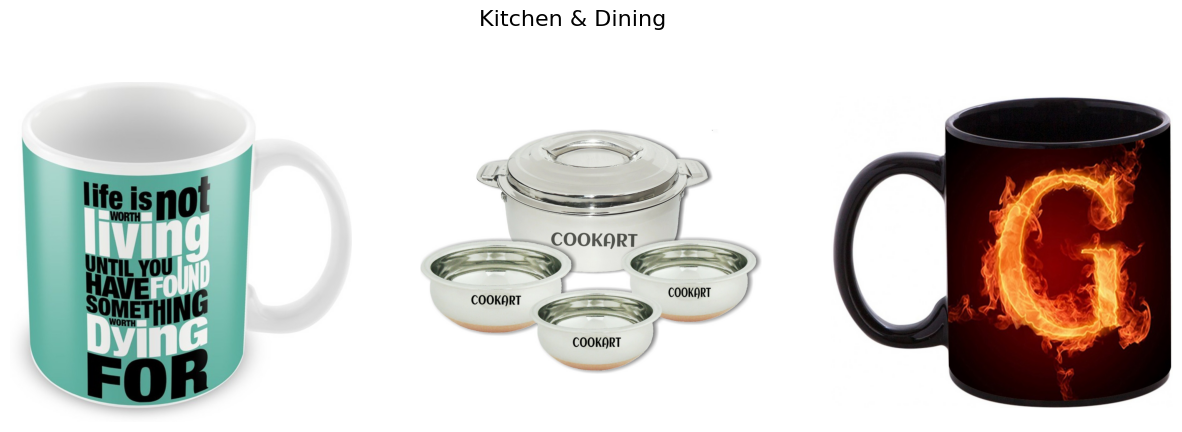

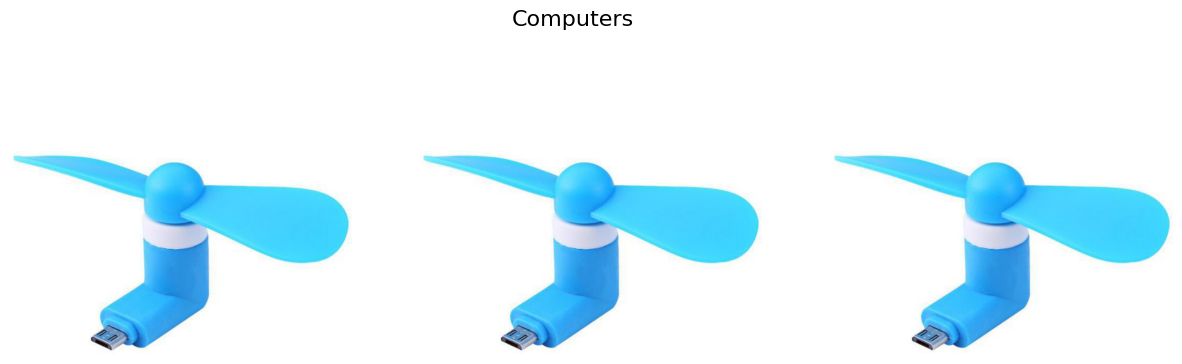

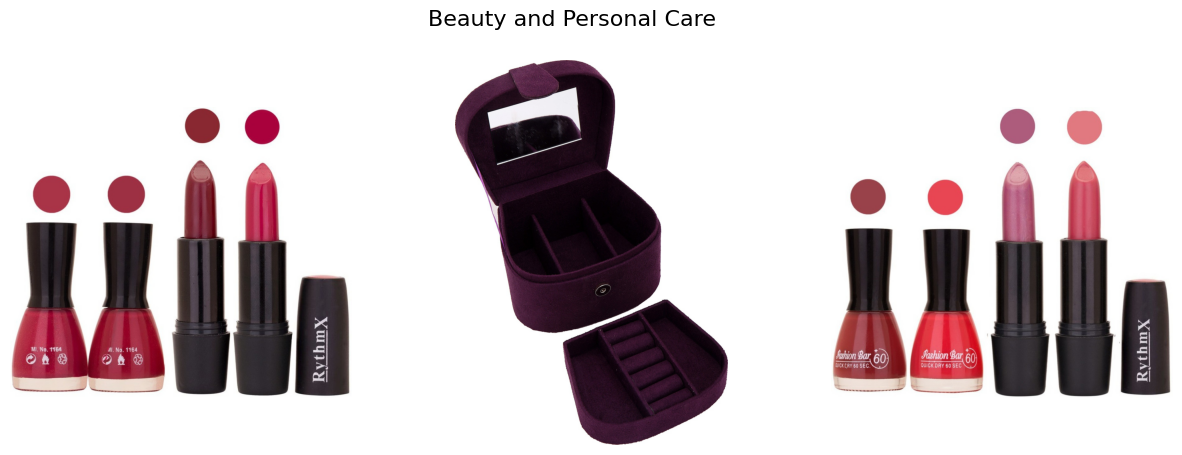

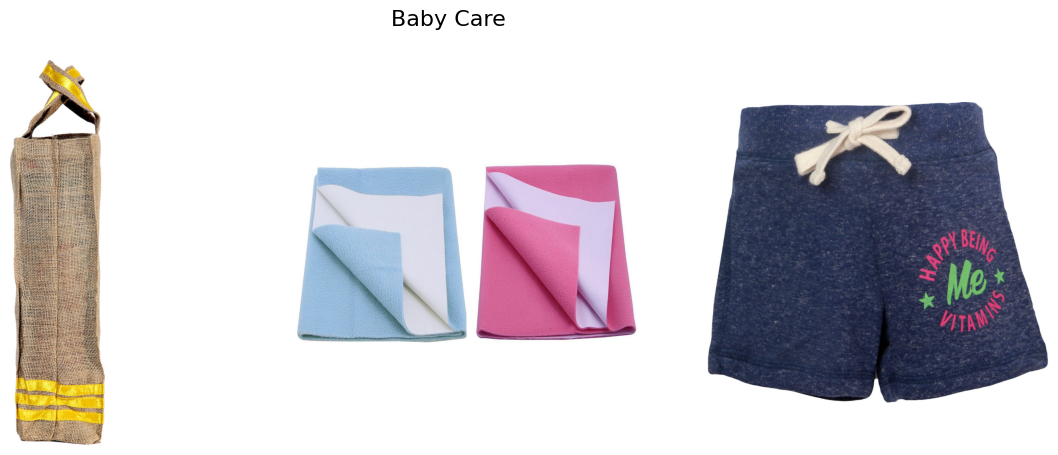

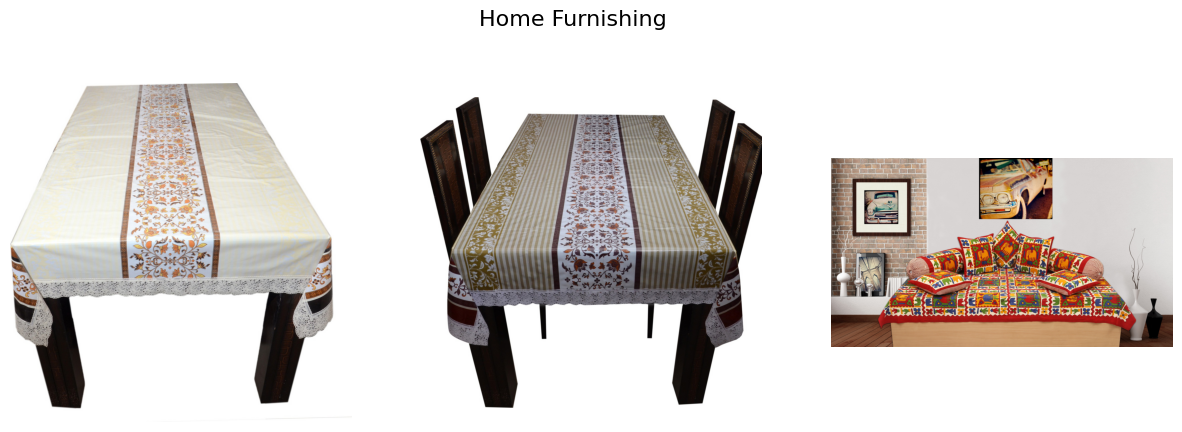

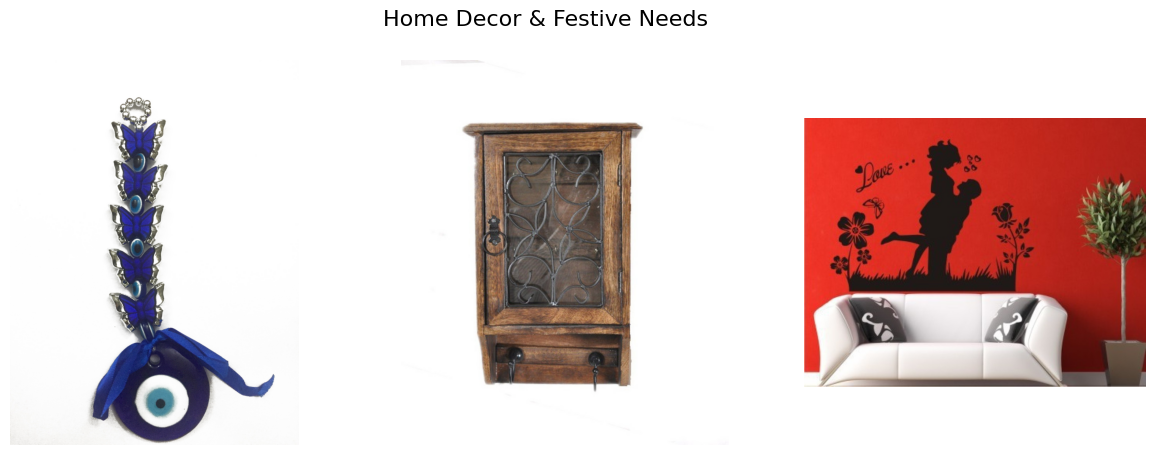

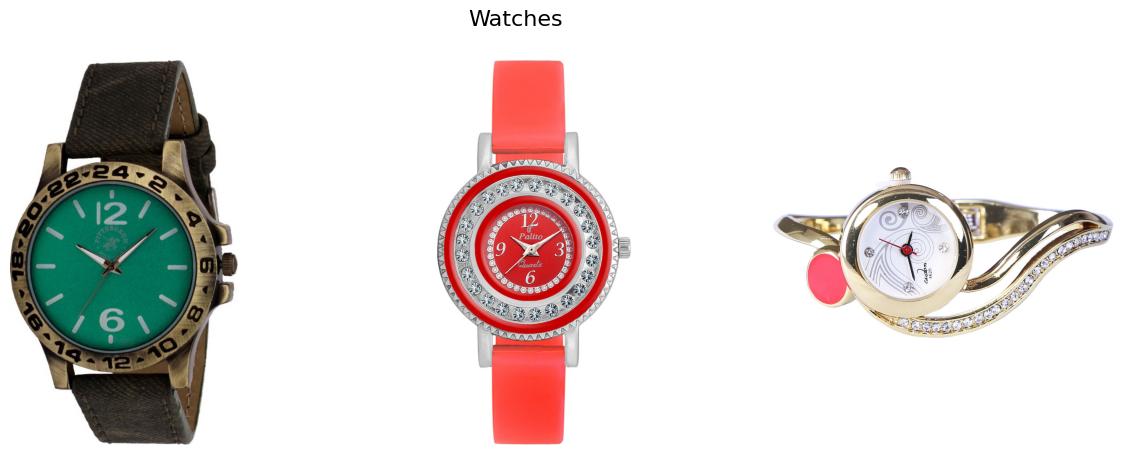

In [ ]:
from matplotlib.image import imread
import os

list_product_category = list(df.product_category.unique())
# Parcourir les catégories de produits
for idx, category in enumerate(list_product_category):
    # Sélectionner les fichiers correspondant à la catégorie
    category_files = df.loc[df.product_category == category, 'image'].tolist()[:3]  # Sélectionner seulement 3 images par catégorie

    # Créer une figure pour cette catégorie
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    fig.suptitle(category, fontsize=16)  # Ajouter un titre à la figure

    # Parcourir les fichiers de la catégorie et afficher les images dans les sous-graphiques correspondants
    for i, filename in enumerate(category_files):
        if i < 3:  # Vérifier si l'index est inférieur à 3
            image = imread(os.path.join(path, filename))
            axes[i].imshow(image)
            # axes[i].set_title(f'Image {i+1}')  # Ajouter un titre à l'image
            axes[i].axis('off')  # Désactiver les axes

    plt.show()  # Afficher la figure pour cette catégorie

## 3. Différentes opérations sur des exemples d'images

In [ ]:
# Sélection d'une image aléatoire :

alea = np.random.randint(0, 1050)
image = imread(os.path.join(path, list_photos[alea]))

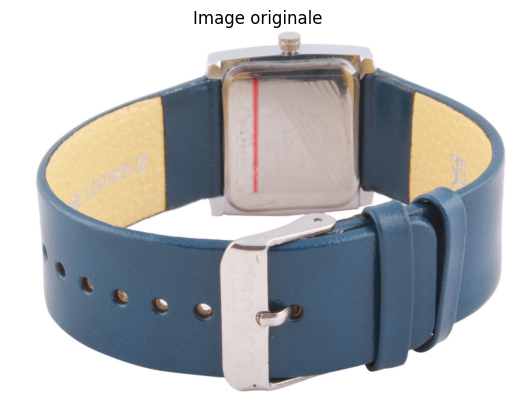

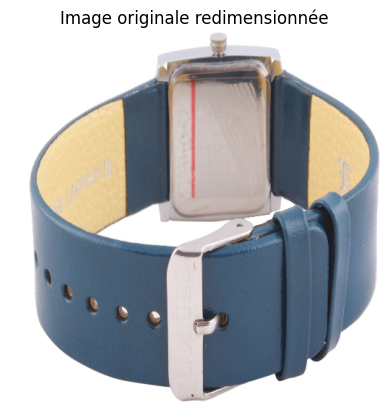

In [ ]:
# Affichage de l'image originale :
plt.figure()
plt.imshow(image)
plt.title('Image originale')
plt.axis('off')
plt.show()

# On redimensionne pour faciliter la visualisation :
resized_image = cv2.resize(image, (512, 512))

# Afficher l'image originale redimensionnée
plt.figure()
plt.imshow(resized_image)
plt.title('Image originale redimensionnée')
plt.axis('off')
plt.show()

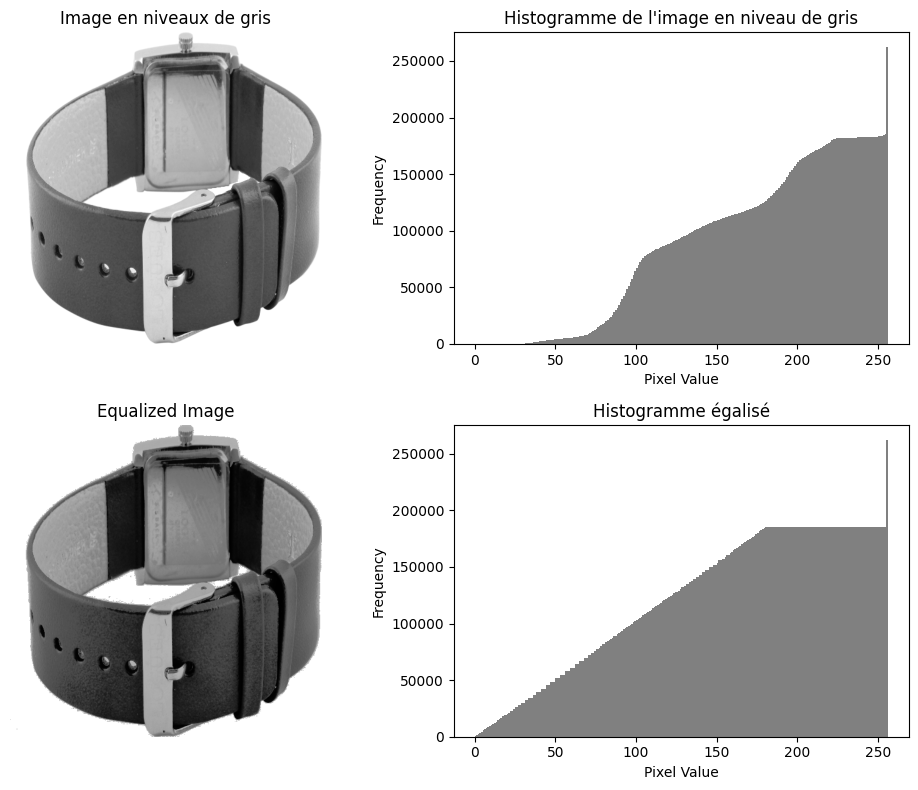

In [ ]:
import cv2

# On passe l'image en niveaux de gris et égalise l'histogramme afin d'améliorer le contraste :

# Conversion en niveaux de gris
grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 8))

# Afficher l'image en niveaux de gris:
plt.subplot(2, 2, 1)
plt.imshow(grayscale_image, cmap='gray')
plt.title('Image en niveaux de gris')
plt.axis('off')

# Afficher l'histogramme de l'image originale
plt.subplot(2, 2, 2)
plt.hist(np.array(grayscale_image).ravel(), bins=256, range=[0,256], color='gray', cumulative = True)
plt.title("Histogramme de l'image en niveau de gris")
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

# Appliquer l'égalisation de l'histogramme :
equalized_image = cv2.equalizeHist(grayscale_image)

# Afficher l'image après égalisation
plt.subplot(2, 2, 3)
plt.imshow(equalized_image, cmap='gray')
plt.title('Equalized Image')
plt.axis('off')

# Afficher l'histogramme de l'image égalisée
plt.subplot(2, 2, 4)
plt.hist(np.array(equalized_image).ravel(), bins=256, range=[0,256], color='gray', cumulative = True)
plt.title('Histogramme égalisé')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

# Afficher les sous-graphiques
plt.tight_layout()
plt.show()

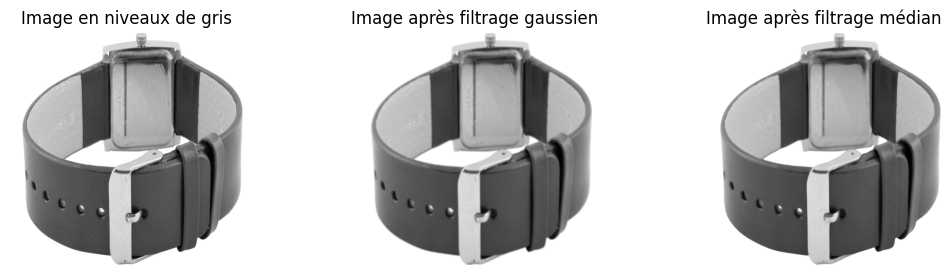

In [ ]:
# Filtrage du bruit et floutage

# Filtrage 'Gaussien'
blurred_image = cv2.GaussianBlur(grayscale_image, (5, 5), 0)  # (5, 5) est la taille du noyau gaussien
# Filtrage médian :
median_filtered_image = cv2.medianBlur(grayscale_image, 5)  # 5 est la taille du noyau

plt.figure(figsize=(12, 8))

# Afficher l'image en niveaux de gris:
plt.subplot(1, 3, 1)
plt.imshow(grayscale_image, cmap='gray')
plt.title('Image en niveaux de gris')
plt.axis('off')

# Afficher l'image après filtrage gaussien :
plt.subplot(1, 3, 2)
plt.imshow(blurred_image, cmap='gray')
plt.axis('off')
plt.title("Image après filtrage gaussien")

# Afficher l'image après filtrage médian :
plt.subplot(1, 3, 3)
plt.imshow(median_filtered_image, cmap='gray')
plt.axis('off')
plt.title("Image après filtrage médian")

# Afficher les sous-graphiques
plt.subplots_adjust(wspace=0.5)
plt.show()

Même chose avec une autre image :

In [ ]:
# Sélection d'une image aléatoire :

alea = np.random.randint(0, 1050)
image = imread(os.path.join(path, list_photos[alea]))

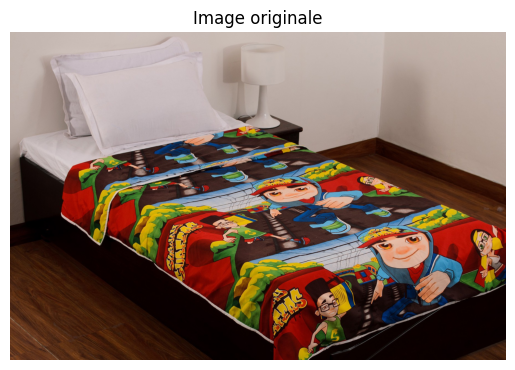

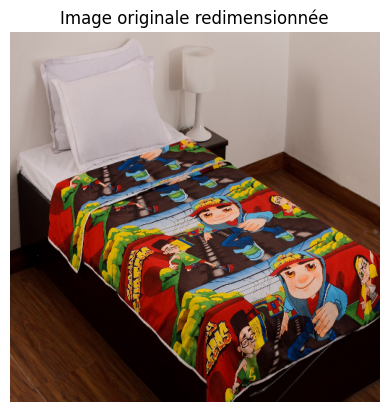

In [ ]:
# Affichage de l'image originale :
plt.figure()
plt.imshow(image)
plt.title('Image originale')
plt.axis('off')
plt.show()

# On redimensionne pour faciliter la visualisation :
resized_image = cv2.resize(image, (512, 512))

# Afficher l'image originale redimensionnée
plt.figure()
plt.imshow(resized_image)
plt.title('Image originale redimensionnée')
plt.axis('off')
plt.show()

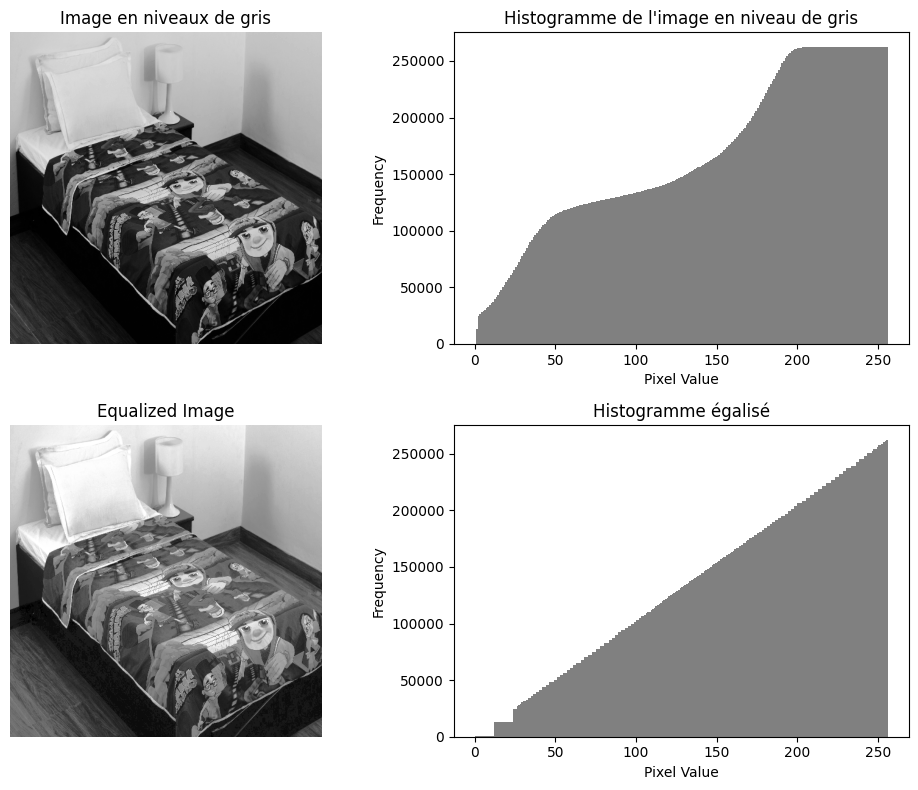

In [ ]:
import cv2

# On passe l'image en niveaux de gris et égalise l'histogramme afin d'améliorer le contraste :

# Conversion en niveaux de gris
grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 8))

# Afficher l'image en niveaux de gris:
plt.subplot(2, 2, 1)
plt.imshow(grayscale_image, cmap='gray')
plt.title('Image en niveaux de gris')
plt.axis('off')

# Afficher l'histogramme de l'image originale
plt.subplot(2, 2, 2)
plt.hist(np.array(grayscale_image).ravel(), bins=256, range=[0,256], color='gray', cumulative = True)
plt.title("Histogramme de l'image en niveau de gris")
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

# Appliquer l'égalisation de l'histogramme :
equalized_image = cv2.equalizeHist(grayscale_image)

# Afficher l'image après égalisation
plt.subplot(2, 2, 3)
plt.imshow(equalized_image, cmap='gray')
plt.title('Equalized Image')
plt.axis('off')

# Afficher l'histogramme de l'image égalisée
plt.subplot(2, 2, 4)
plt.hist(np.array(equalized_image).ravel(), bins=256, range=[0,256], color='gray', cumulative = True)
plt.title('Histogramme égalisé')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

# Afficher les sous-graphiques
plt.tight_layout()
plt.show()

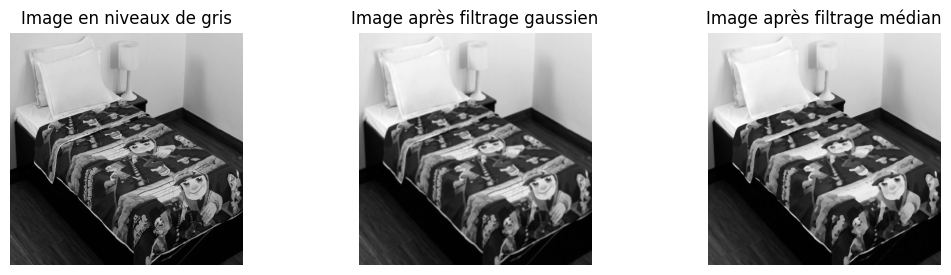

In [ ]:
# Filtrage du bruit et floutage

# Filtrage 'Gaussien'
blurred_image = cv2.GaussianBlur(grayscale_image, (5, 5), 0)  # (5, 5) est la taille du noyau gaussien
# Filtrage médian :
median_filtered_image = cv2.medianBlur(grayscale_image, 5)  # 5 est la taille du noyau

plt.figure(figsize=(12, 8))

# Afficher l'image en niveaux de gris:
plt.subplot(1, 3, 1)
plt.imshow(grayscale_image, cmap='gray')
plt.title('Image en niveaux de gris')
plt.axis('off')

# Afficher l'image après filtrage gaussien :
plt.subplot(1, 3, 2)
plt.imshow(blurred_image, cmap='gray')
plt.axis('off')
plt.title("Image après filtrage gaussien")

# Afficher l'image après filtrage médian :
plt.subplot(1, 3, 3)
plt.imshow(median_filtered_image, cmap='gray')
plt.axis('off')
plt.title("Image après filtrage médian")

# Afficher les sous-graphiques
plt.subplots_adjust(wspace=0.5)
plt.show()

## 4. Utilisation de SIFT pour de l'extraction de features

SIFT permet de trouver des features dans une image via des détecteurs et des descripteurs.
Commençons par l'utiliser sur une image.

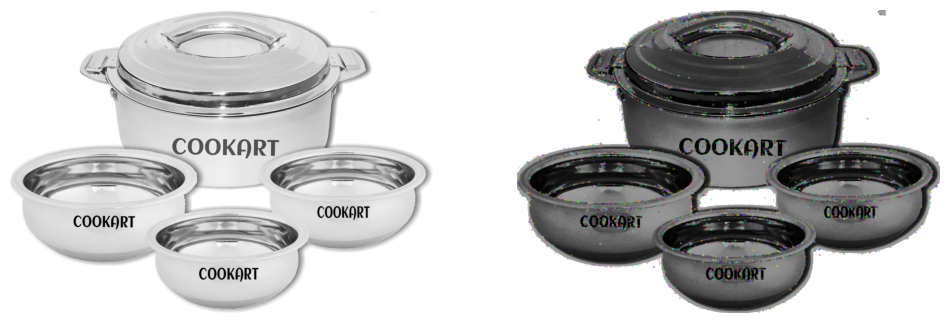

In [ ]:
# On sélectionne une image
file_path = os.path.join(path, list_photos[1])
image = imread(file_path)

# On crée un objet SIFT
sift = cv2.SIFT_create()

# Passage en niveaux de gris :
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Egalisation de l'histogramme :
equalized_image = cv2.equalizeHist(gray_image)

# Détection des points d'intérêt des descripteurs
kp, des = sift.detectAndCompute(equalized_image, None)

# On "applique" les points d'intérêts sur l'image:
img_with_keypoints = cv2.drawKeypoints(equalized_image, kp, None)

# Visualisation de l'image originale (en niveaux de gris) et de celle avec les keypoints :

plt.figure(figsize=(12, 8))

# Originale :
plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.axis('off')

# Avec Keypoints :
plt.subplot(1, 2, 2)
plt.imshow(img_with_keypoints)
plt.axis('off')

plt.show()

In [ ]:
# Affichage des dimensions du descritpeurs et de ses valeurs :
print("Descriptor shape:", des.shape)
print()
print(des)

Descriptor shape: (3078, 128)

[[ 10.   0.   0. ...   0.   0.   0.]
 [  3.   0.   0. ...   0.   0.   0.]
 [  3.   1.   1. ...   0.   0.   3.]
 ...
 [ 56. 142.  49. ...   0.   0.   0.]
 [  5.   0.   0. ...   0.   0.   1.]
 [ 26.  10.   0. ...   0.   0.   1.]]


Même chose sur une image sélectionnée au hasard :

In [ ]:
# Sélection d'une image aléatoire :

alea = np.random.randint(0, 1050)
image = imread(os.path.join(path, list_photos[alea]))

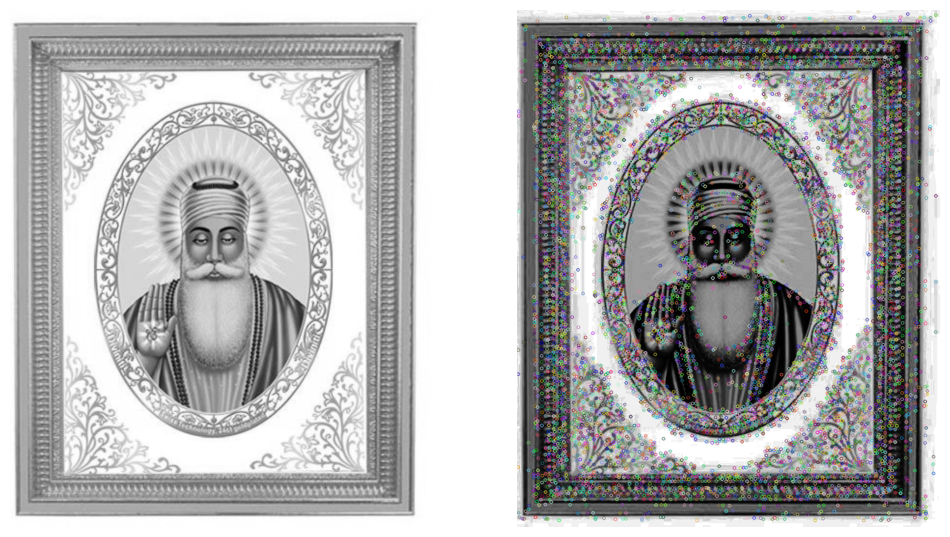

In [ ]:
# On crée un objet SIFT
sift = cv2.SIFT_create()

# Passage en niveaux de gris :
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Egalisation de l'histogramme :
equalized_image = cv2.equalizeHist(gray_image)

# Détection des points d'intérêt des descripteurs
kp, des = sift.detectAndCompute(equalized_image, None)

# On "applique" les points d'intérêts sur l'image:
img_with_keypoints = cv2.drawKeypoints(equalized_image, kp, None)

# Visualisation de l'image originale (en niveaux de gris) et de celle avec les keypoints :

plt.figure(figsize=(12, 8))

# Originale :
plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.axis('off')

# Avec Keypoints :
plt.subplot(1, 2, 2)
plt.imshow(img_with_keypoints)
plt.axis('off')

plt.show()

In [ ]:
# Affichage des dimensions du descritpeurs et de ses valeurs :
print("Descriptor shape:", des.shape)
print()
print(des)

Descriptor shape: (10126, 128)

[[146.   0.   0. ...   0.   0.   0.]
 [149.   0.   0. ...   0.   0.   0.]
 [143.   0.   0. ...   0.   0.   0.]
 ...
 [  0.  42.   7. ...   1.   0.   7.]
 [  0.   1.   7. ...   0.   3.  60.]
 [112.  10.   3. ...   0.   0.   0.]]


On voit qu'on peut avoir des dimensions de descripteurs assez variables.

### Créations des descripteurs de chaque image
* Pour chaque image passage en gris et égalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [ ]:
# Application à l'ensemble de nos images :

import time
from PIL import Image
# Liste des keypoints :
sift_keypoints = []

temps1 = time.time()
# On crée notre objet SIFT en indiquant un nombre maximal de descripteurs par image :
sift = cv2.SIFT_create(500)
max_descriptors = 0

for image_num in range(len(list_photos)):

    if image_num % 100 == 0:
        print(image_num)

    image_pil = Image.open(path + list_photos[image_num])
    image_gray_pil = image_pil.convert('L') # conversion en gris
    image = np.array(image_gray_pil)
    resized_image = cv2.resize(image, (512, 512))

    # Égaliser l'histogramme de l'image redimensionnée
    res = cv2.equalizeHist(resized_image)

    # Détecter les points d'intérêt et calculer les descripteurs
    kp, des = sift.detectAndCompute(res, None)

    # Vérifier si des descripteurs ont été trouvés
    if des is not None and len(des) > 0:
        # Ajouter les descripteurs à la liste
        sift_keypoints.append(des)
    # Mettre à jour la taille maximale des descripteurs
    max_descriptors = max(max_descriptors, des.shape[0])

# Remplir les descripteurs manquants avec des valeurs nulles
for i in range(len(sift_keypoints)):
    des = sift_keypoints[i]
    if des.shape[0] < max_descriptors:
        missing_descriptors = max_descriptors - des.shape[0]
        sift_keypoints[i] = np.vstack([des, np.zeros((missing_descriptors, des.shape[1]), dtype=np.float32)])

# Convertir la liste de descripteurs en un tableau NumPy
sift_keypoints_by_img = np.asarray(sift_keypoints)

# Concaténer les descripteurs de toutes les images
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1 = time.time() - temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000

Nombre de descripteurs :  (528150, 128)
temps de traitement SIFT descriptor :           142.95 secondes


In [ ]:
sift_keypoints_by_img.shape

(1050, 503, 128)

### Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

La littérature "propose" souvent 2 choix pour le nombre de clusters de descripteurs :
* la racine carrée du nombre de descripteurs
* le nombre de catégories réelles multipliée par 10.

Nous considérerons ici la première option.

L'idée est donc ici de regrouper les différents descripteurs en un certain nombre de clusters. A chaque image sera alors associée un certains nombres de clusters de descpriteurs.

In [ ]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
# k = 70
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  727
Création de 727 clusters de descripteurs ...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


temps de traitement kmeans :            18.09 secondes


### Création des features des images
* Pour chaque image :
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [ ]:
# Création des histogrammes (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             3.62 secondes


### Réductions de dimension

#### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (ici on gardera 99% de la variance)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [ ]:
from sklearn.decomposition import PCA

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = PCA(n_components = 0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)


Dimensions dataset avant réduction PCA :  (1050, 727)
Dimensions dataset après réduction PCA :  (1050, 331)


#### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30,
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["product_category"]
print(df_tsne.shape)

(1050, 3)


### Analyse visuelle : affichage T-SNE selon catégories d'images

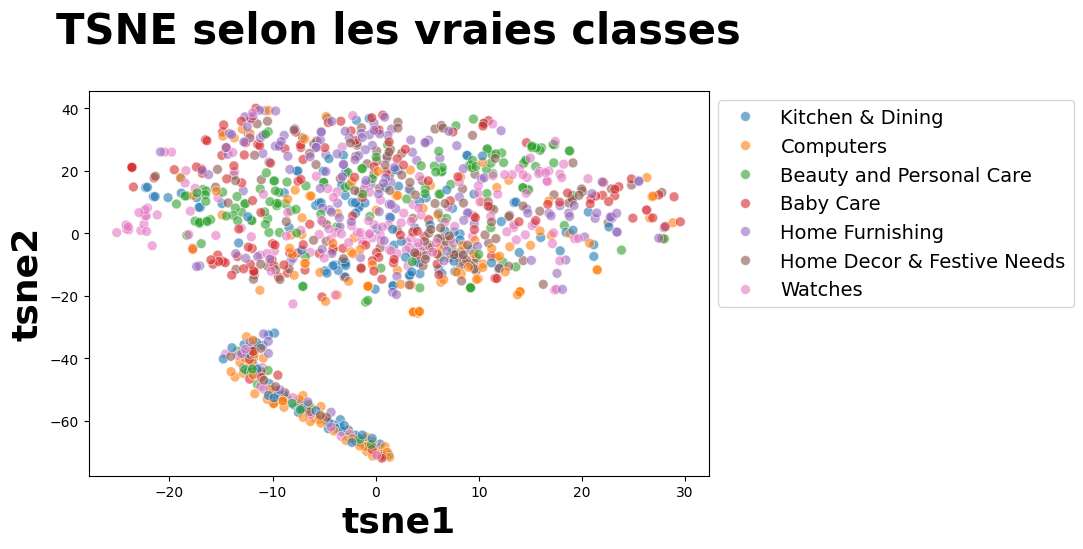

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}, bbox_to_anchor=(1,1))

plt.show()

A première vue cette méthode ne semble pas pouvoir prédire les catégories de produits à partir de leurs images.

### Analyse mesures : similarité entre catégories et clusters

####  Création de clusters à partir du T-SNE

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

cls = KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### Après avoir effectué un clustering, on calcul l'ARI, indice de similarité entre les catégories réelles et les labels des clusters.

In [ ]:
# Calcul de l'ARI :

labels = df["label"]
print("ARI : ", adjusted_rand_score(labels, cls.labels_))

ARI :  0.05174550050319949


On confirme par cette valeur de l'ARI très faible que cette méthode ne permet pas de prédire et classifier les produits à partir de leurs images.

#### Création et visualisation d'une matrice de confusion

In [ ]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[20  5 25 39 18 41  2]
 [56  6 47 12 15  8  6]
 [12 24 15 10 30 33 26]
 [14  9 29 34 43 14  7]
 [19  6 27 67 15 14  2]
 [26 25 12 11 33 18 25]
 [39  7 30  7 40 21  6]]


In [ ]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)

    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])

    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [1 5 1 4 3 0 2]
[[ 41  45   2  18  39   5   0]
 [  8 103   6  15  12   6   0]
 [ 33  27  26  30  10  24   0]
 [ 14  43   7  43  34   9   0]
 [ 14  46   2  15  67   6   0]
 [ 18  38  25  33  11  25   0]
 [ 21  69   6  40   7   7   0]]

              precision    recall  f1-score   support

           0       0.28      0.27      0.27       150
           1       0.28      0.69      0.40       150
           2       0.35      0.17      0.23       150
           3       0.22      0.29      0.25       150
           4       0.37      0.45      0.41       150
           5       0.30      0.17      0.22       150
           6       0.00      0.00      0.00       150

    accuracy                           0.29      1050
   macro avg       0.26      0.29      0.25      1050
weighted avg       0.26      0.29      0.25      1050



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

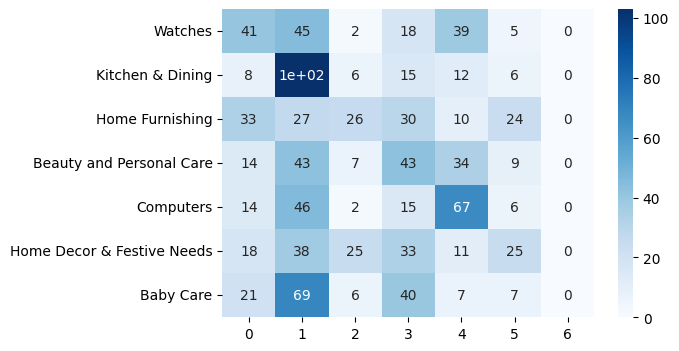

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## 5. Approche CNN - Etude de faisabilité

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

On utilisera ici le modèle VGG16 pré-entrainé afin d'extraire des features de notre jeu de données et de se prononcer sur la faisabilité d'une classification des produits à partir des images.

### Création du modèle pré-entraîné

In [ ]:
# On instancie le modèle en retirant la dernière couche du réseau
# Nous souhaitons ici utiliser le modèle pour créer des features à partir de nos images
base_model = VGG16(weights="imagenet")
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

553467096/553467096 [==============================] - 6s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

### Création des features des images

In [ ]:
# On crée nos features :

images_features = []
i=0
for image_num in range(len(list_photos)) :
    if i%100 == 0 : print(i)
    i +=1
    # le modèle prend en entrée des images de taille (224, 224) :
    image = load_img(path + list_photos[image_num], target_size=(224, 224))
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000


(1050, 4096)

### Réduction dimension et analyse
* De la même manière qu'avec l'approche précédente, nous procédons à des réductions de dimension de nos données, utiles notamment pour la visualisation par TNSE

#### Réduction de dimension PCA

In [ ]:
print(images_features.shape)
pca = PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 803)


On voit que même en conservant 99% de la variance présente dans nos données, on peut significativement en réduire les dimensions, passant de 4096 à 803.

#### Réduction de dimension T-SNE et affichage des images selon vraies classes

In [ ]:
temps1 = time.time()

tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :            18.98 secondes


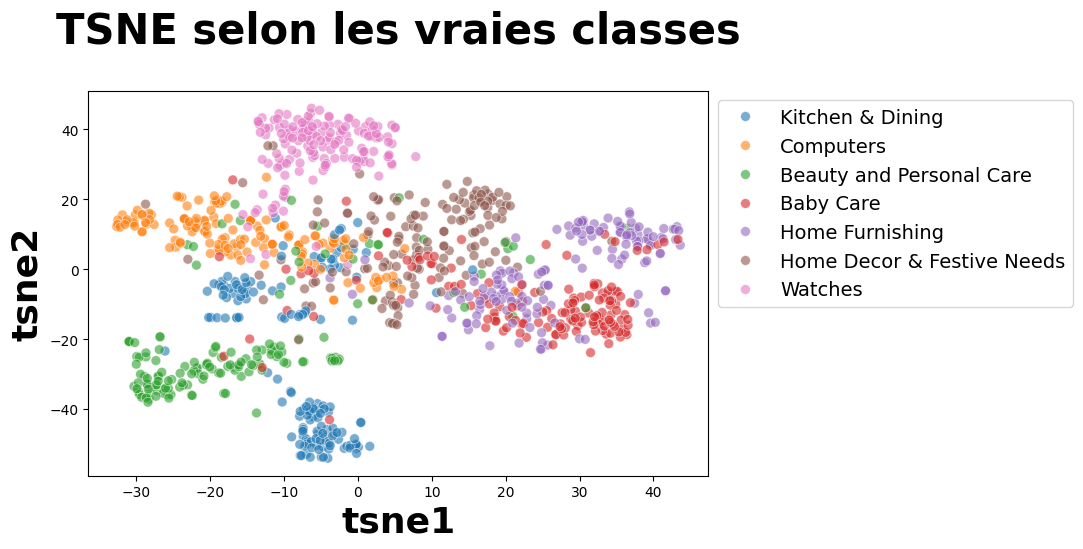

In [ ]:
# Visualisation selon les vraies catégories :

df_tsne_dl = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne_dl["class"] = df["product_category"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne_dl,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}, bbox_to_anchor=(1,1))

plt.show()

On note une bien meilleure représentation et distinction des différentes catégories qu'avec la méthode SIFT ici.

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


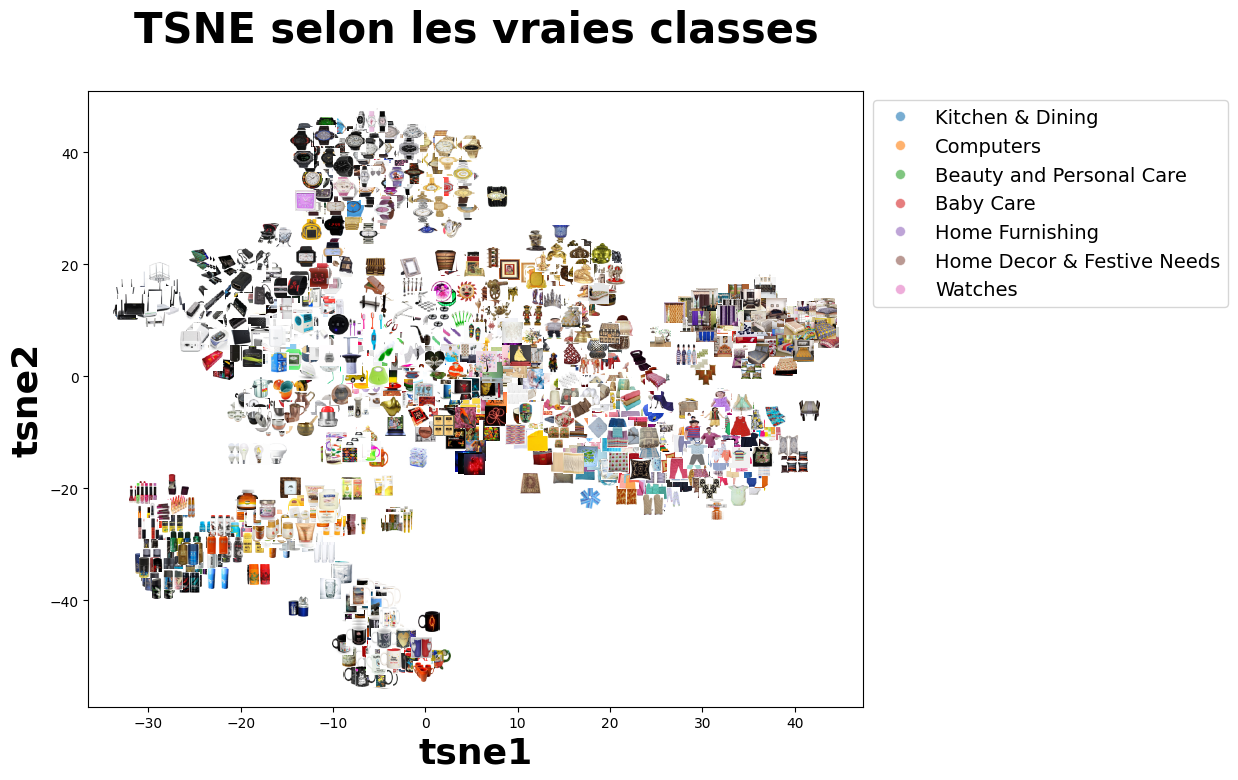

In [ ]:
# Tentative d'affichage avec les images des produits :

from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Fonction pour afficher les images aux coordonnées TSNE avec redimensionnement
def plot_images_on_tsne(df, ax, target_size=(30, 30)):
    for index, row in df.iterrows():
        image_path = path + list_photos[index]
        img = Image.open(image_path)
        img = img.resize(target_size)  # Redimensionnement de l'image
        img = OffsetImage(np.array(img), zoom=0.5)  # Conversion en format compatible avec OffsetImage
        ab = AnnotationBbox(img, (row['tsne1'], row['tsne2']), frameon=False, pad=0.0)
        ax.add_artist(ab)

plt.figure(figsize=(10, 8))

# Création du graphique scatterplot
ax = sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne_dl,
    legend="brief"
)

plt.title('TSNE selon les vraies classes', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14}, bbox_to_anchor=(1, 1))

# Appel de la fonction pour afficher les images sur le graphique
plot_images_on_tsne(df_tsne_dl, ax)

plt.show()


#### Création de clusters à partir du T-SNE

In [ ]:
cls = KMeans(n_clusters=7, n_init='auto', random_state = 6)
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init='auto', random_state=6)

In [ ]:
labels = df["label"]
print("ARI : ", adjusted_rand_score(labels, cls.labels_))

ARI :  0.5073818968248538


Le calcul de l'ARI nous confirme une nette amélioration en utilisant cette approche. Cela nous amène à conclure qu'une classification supervisée à partir des images, en vue de prédire la catégorie des produits, semble réalisable.

#### Création et visualisation d'une matrice de confusion

In [ ]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[ 12   1   0 119   3   2  13]
 [  7   1   0   7 116   8  11]
 [  2   0   1   1   0 105  41]
 [ 97   0   3   5   1   7  37]
 [  9   0   0 136   0   0   5]
 [  2  78   0   0  10   1  59]
 [  0   0 133   0   0  14   3]]


In [ ]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [3 5 6 4 1 2 5]
[[  0   3   2  12 119  14   0]
 [  0 116   8   7   7  12   0]
 [  0   0 105   2   1  41   1]
 [  0   1   7  97   5  37   3]
 [  0   0   0   9 136   5   0]
 [  0  10   1   2   0 137   0]
 [  0   0  14   0   0   3 133]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       0.89      0.77      0.83       150
           2       0.77      0.70      0.73       150
           3       0.75      0.65      0.70       150
           4       0.51      0.91      0.65       150
           5       0.55      0.91      0.69       150
           6       0.97      0.89      0.93       150

    accuracy                           0.69      1050
   macro avg       0.63      0.69      0.65      1050
weighted avg       0.63      0.69      0.65      1050



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

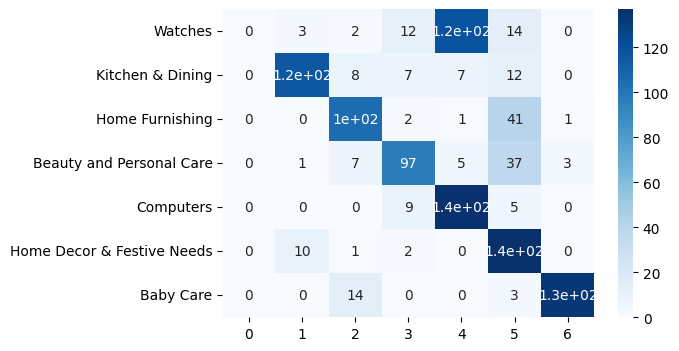

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")